## X-ray_CT_Segmentation(Tensorflow)

X-ray_CT 데이터를 가지고 세그멘테이션을 진행해보겠습니다.

모델은 U-Net으로 진행해보았습니다.

중간에 데이터를 잘못 옮긴 탓인지 예측이 이상하게 나왔습니다.

그건 추후에 수정하겠습니다.

###구글 드라이브 임포트

In [1]:
from google.colab import drive
drive.mount('drive')

Mounted at drive


---

###라이브러리 호출

In [2]:
import os
import numpy as np
import pandas as pd
import PIL
from PIL import Image
import cv2
from glob import glob

---

###원본 데이터 넘파이 형태로 저장

In [5]:
root = '/content/drive/MyDrive/pic/gimo_data/x_train/'
training_images = []

for img in glob(root + "/*.tif"):
    an_img = Image.open(img)
    img_array = np.array(an_img)
    img_resize = cv2.resize(img_array, (64, 64))
    training_images.append(img_resize)

training_images = np.array(training_images)

print(training_images.shape)

(1407, 64, 64)


---

###시각화하여 확인

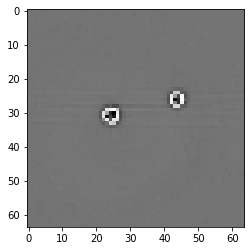

In [6]:
import matplotlib.pyplot as plt

plt.imshow(training_images[0], cmap = 'gray')
plt.show()

---

##라벨 데이터 넘파이 형태로 저장

In [5]:
root = '/content/drive/MyDrive/pic/gimo_data/y_train/'
mask_images = []

for img in glob(root + "/*.tif"):
    an_img = Image.open(img)
    img_array = np.array(an_img)
    img_resize = cv2.resize(img_array, (64, 64))
    mask_images.append(img_resize)

mask_images = np.array(mask_images)

print(mask_images.shape)

(1407, 64, 64)


---

###채널 늘리기 및 정규화

In [6]:
training_images = training_images.reshape((training_images.shape[0], training_images.shape[1], training_images.shape[2], 1))
training_images.shape

(1407, 64, 64, 1)

In [7]:
training_images = training_images.astype('float32')

In [ ]:
for i in range(len(training_images)):
    new_img = (training_images[i] - np.min(training_images[i])) / (np.max(training_images[i]) - np.min(training_images[i]))
    training_images[i] = np.expand_dims(new_img[:,:,0], axis = 2)

---

###채널 늘리기 및 정규화2

In [10]:
mask_images = mask_images.reshape((mask_images.shape[0], mask_images.shape[1], mask_images.shape[2], 1))
print(mask_images.shape, mask_images.max())

(1407, 64, 64, 1) 2


In [ ]:
mask_mapping = {(204,204,179): 0, (0,100,0):0.5, (0,0,255):1}
for i in range(len(mask_images)):
  img = mask_images[i]
  for k in mask_mapping:
    img[(img == k).all(axis=2)] = mask_mapping[k]
    img = img.astype('float32')
    tmp = img[:,:,0]
  mask_images[i] = np.expand_dims(tmp, axis = 2)

---

###정규화 확인

In [12]:
print(training_images.max(), mask_images.max())

1.0 1.0


---

###시각화

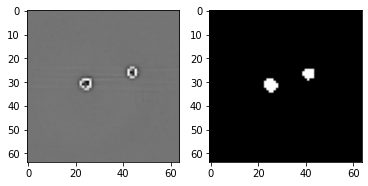

In [13]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(training_images[0].squeeze(), cmap = 'gray')
ax[1].imshow(mask_images[0].squeeze(), cmap = 'gray')
plt.show()

---

###데이터 분리 및 모델 제작

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test = train_test_split(training_images, test_size = 0.2, random_state=50)
y_trainY, y_test = train_test_split(mask_images, test_size = 0.2, random_state=50)

In [15]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

def build_model(input_shape = X_train[0].shape):

    inputs = Input(input_shape)

    #다운 샘플링
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)
 
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(pool4)  
    conv5 = Conv2D(1024, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv5)
 
    #업 샘플링
    drop5 = Dropout(0.5)(conv5)
    up6 = Conv2DTranspose(512, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(drop5)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv6)
    up7 = Conv2DTranspose(256, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv6)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv7)
    up8 = Conv2DTranspose(128, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv7)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv8)
    up9 = Conv2DTranspose(64, 2, activation='relu', strides=(2,2), kernel_initializer='he_normal')(conv8)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)  
    conv9 = Conv2D(2, 3, activation='relu', padding='same',kernel_initializer='he_normal')(conv9)    
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs = inputs, outputs = conv10)
    return model

----

###모델 확인

In [16]:
unet = build_model()
unet.compile(optimizer = Adam(1e-4), loss = 'binary_crossentropy')
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 64)   640         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 32, 32, 64)   0           ['conv2d_1[0][0]']               
                                                                                              

----

###모델 학습

In [17]:
ba_model = unet.fit(
    X_train,
    y_trainY,
    batch_size = 16,
    epochs = 15,
)

Epoch 1/15
71/71 [==============================] - 19s 102ms/step - loss: 0.1945
Epoch 2/15
71/71 [==============================] - 5s 77ms/step - loss: 0.1536
Epoch 3/15
71/71 [==============================] - 5s 77ms/step - loss: 0.1475
Epoch 4/15
71/71 [==============================] - 5s 77ms/step - loss: 0.1297
Epoch 5/15
71/71 [==============================] - 5s 77ms/step - loss: 0.1001
Epoch 6/15
71/71 [==============================] - 6s 78ms/step - loss: 0.0984
Epoch 7/15
71/71 [==============================] - 6s 78ms/step - loss: 0.0984
Epoch 8/15
71/71 [==============================] - 6s 79ms/step - loss: 0.0981
Epoch 9/15
71/71 [==============================] - 6s 79ms/step - loss: 0.0970
Epoch 10/15
71/71 [==============================] - 6s 79ms/step - loss: 0.0954
Epoch 11/15
71/71 [==============================] - 6s 80ms/step - loss: 0.0943
Epoch 12/15
71/71 [==============================] - 6s 80ms/step - loss: 0.0953
Epoch 13/15
71/71 [================

---

###결과 확인

위에서 말씀 드렸다 싶이 데이터를 거꾸로 넣어 200장 정도 다른 데이터가 들어갔습니다.

추후에 데이터를 다시 정렬하여 고쳐놓겠습니다.

In [21]:
predictions1 = unet.predict(X_test)

9/9 [==============================] - 0s 49ms/step


---

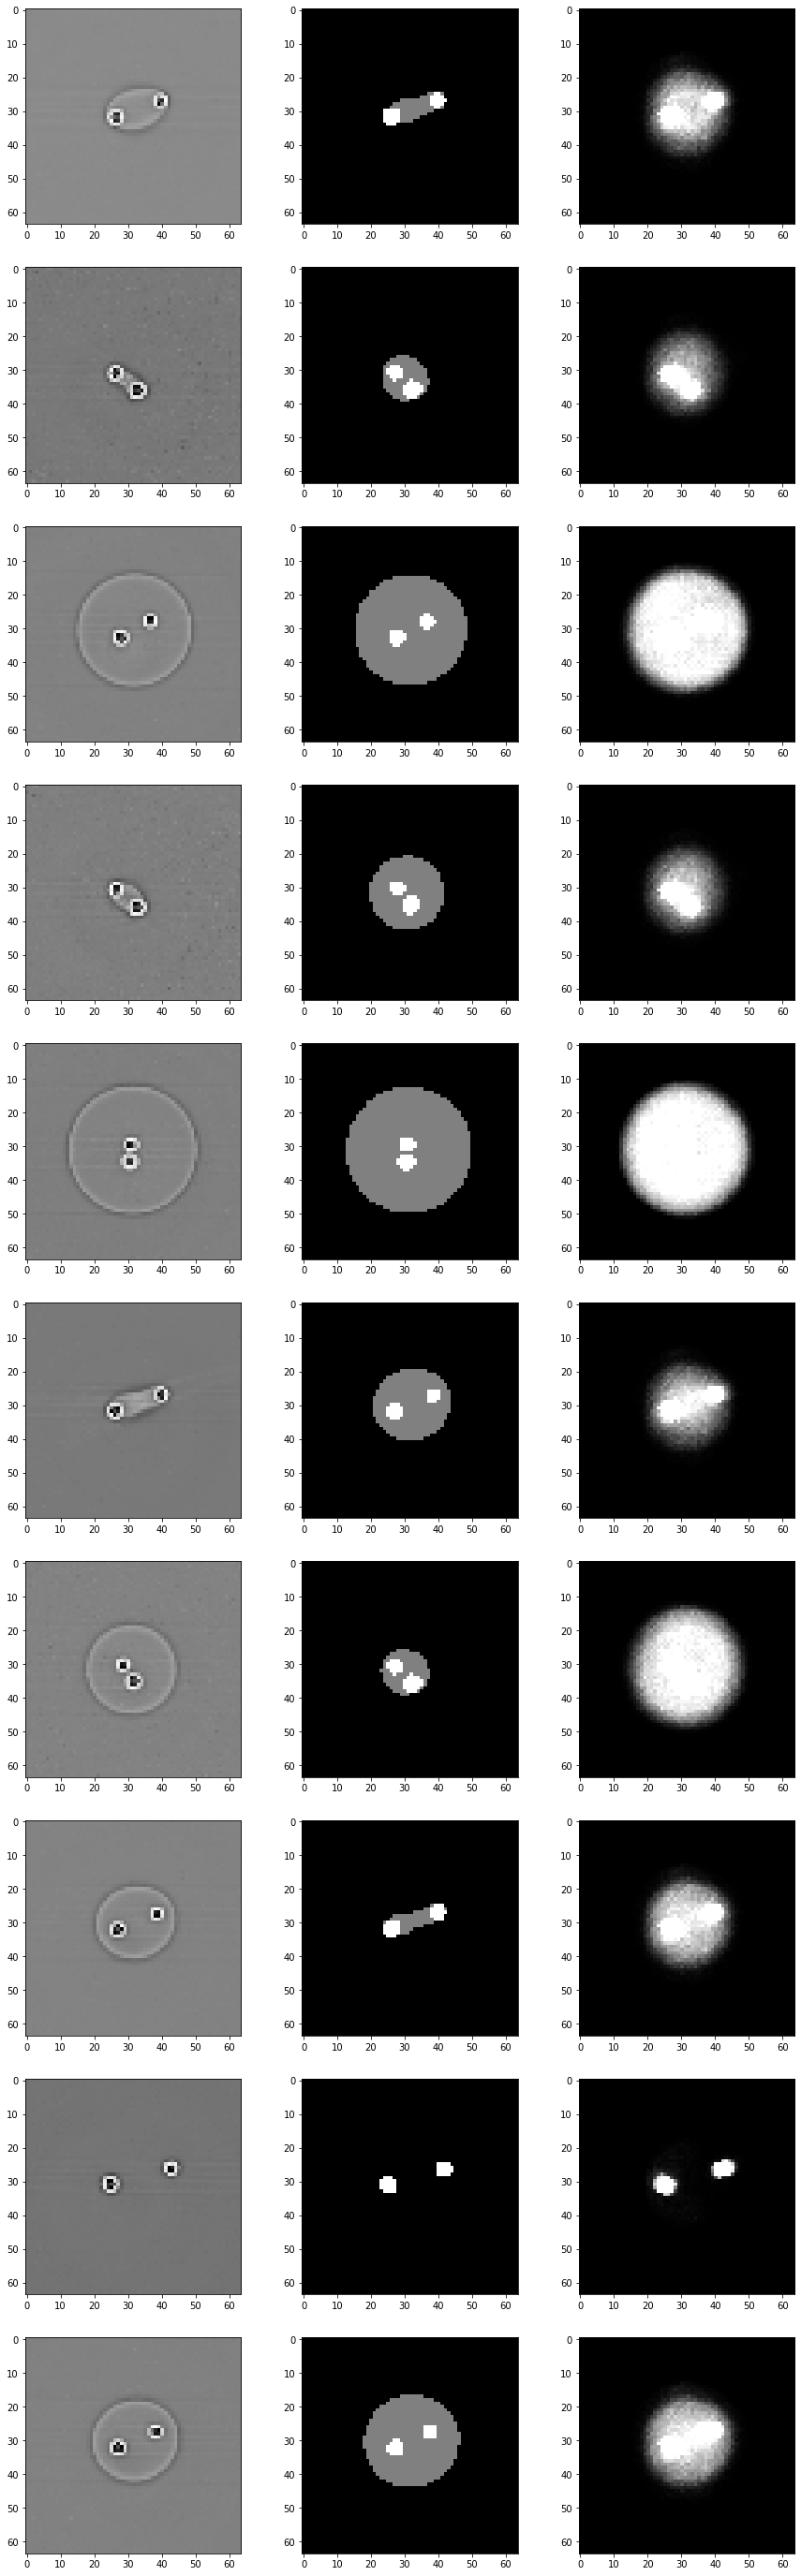

In [22]:
show_num = 10
fig, ax = plt.subplots(show_num, 3, figsize=(15, 50))

for i, pred in enumerate(predictions1[:show_num]):
    ax[i, 0].imshow(X_test[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(y_test[i].squeeze(), cmap='gray')
    ax[i, 2].imshow(pred.squeeze(), cmap='gray')